# Importing libraries

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import  classification_report, confusion_matrix, roc_curve, auc
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree

# Loading dataset

In [2]:
train = pd.read_csv("datasets/train.csv")
test = pd.read_csv("datasets/test.csv")

In [3]:
X_train, y_train =  train.drop(["Depression"], axis=1), train["Depression"]
X_test, y_test =  test.drop(["Depression"], axis=1), test["Depression"]

# Model training

In [4]:
dt = DecisionTreeClassifier()

In [5]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']
}

In [6]:
grid_search = RandomizedSearchCV(estimator=dt, param_distributions=param_grid,  scoring='accuracy', cv=5, verbose=2, n_jobs=-1)

In [7]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [3, 5, 10, None],
                                        'max_features': [None, 'sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10]},
                   scoring='accuracy', verbose=2)

# Model Evaluation

In [8]:
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validated Accuracy: {grid_search.best_score_}")

Best Parameters: {'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': None, 'max_depth': 3, 'criterion': 'gini'}
Best Cross-Validated Accuracy: 0.8208926621821023


In [9]:
# Evaluate the model on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print("\nClassification Report:\n", classification_report(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.72      0.78      2320
           1       0.82      0.90      0.86      3247

    accuracy                           0.82      5567
   macro avg       0.83      0.81      0.82      5567
weighted avg       0.83      0.82      0.82      5567



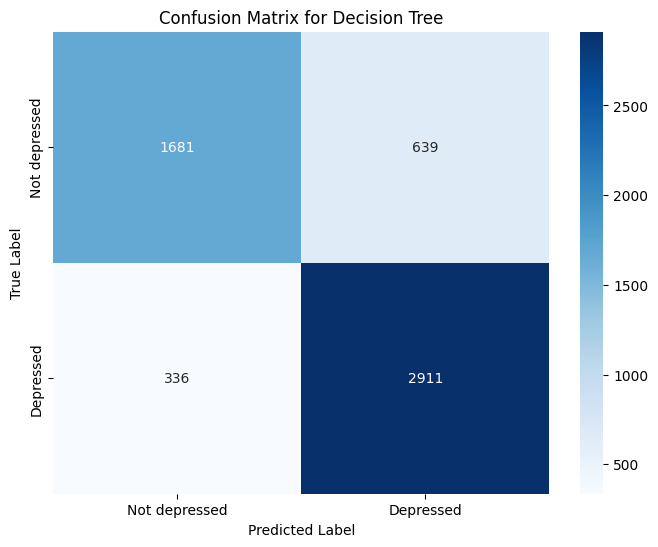

In [10]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Not depressed", "Depressed"],
            yticklabels=["Not depressed", "Depressed"])
plt.title("Confusion Matrix for Decision Tree")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# AUROC Curve

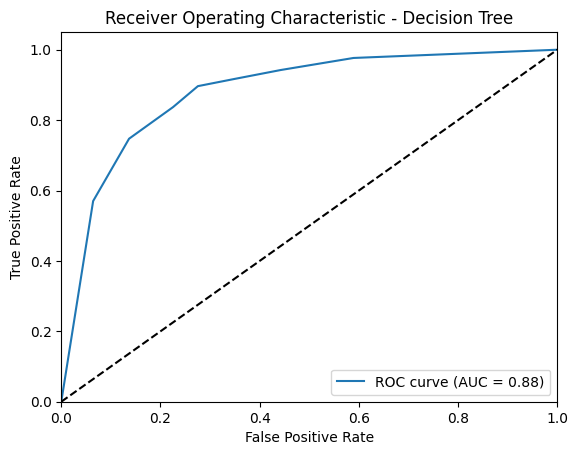

In [21]:
y_prob = best_model.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Decision Tree')
plt.legend(loc="lower right")
plt.show()

# Feature importance

In [12]:
# Get feature importances
importances = best_model.feature_importances_

# Print feature importances
for feature, importance in sorted(zip(train.columns, importances), key=lambda x: x[1], reverse=True):
    print(f"{feature}: {importance:.4f}")

Have you ever had suicidal thoughts ?: 0.5989
Academic Pressure: 0.2431
Financial Stress: 0.1026
Age: 0.0267
Dietary Habits: 0.0194
Work/Study Hours: 0.0064
Study Satisfaction: 0.0028
Gender: 0.0000
City: 0.0000
CGPA: 0.0000
Sleep Duration: 0.0000
Degree: 0.0000
Family History of Mental Illness: 0.0000


In [13]:
tree_rules = export_text(best_model, feature_names=list(X_train.columns))
print(tree_rules)

|--- Have you ever had suicidal thoughts ? <= 0.50
|   |--- Academic Pressure <= 3.50
|   |   |--- Financial Stress <= 3.50
|   |   |   |--- Dietary Habits <= 1.50
|   |   |   |   |--- Academic Pressure <= 2.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- Academic Pressure >  2.50
|   |   |   |   |   |--- class: 0
|   |   |   |--- Dietary Habits >  1.50
|   |   |   |   |--- Academic Pressure <= 2.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- Academic Pressure >  2.50
|   |   |   |   |   |--- class: 0
|   |   |--- Financial Stress >  3.50
|   |   |   |--- Academic Pressure <= 2.50
|   |   |   |   |--- Dietary Habits <= 1.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- Dietary Habits >  1.50
|   |   |   |   |   |--- class: 0
|   |   |   |--- Academic Pressure >  2.50
|   |   |   |   |--- Age <= 24.50
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- Age >  24.50
|   |   |   |   |   |--- class: 0
|   |--- Academic Pressure >  3.50
|   |   |--- Financia

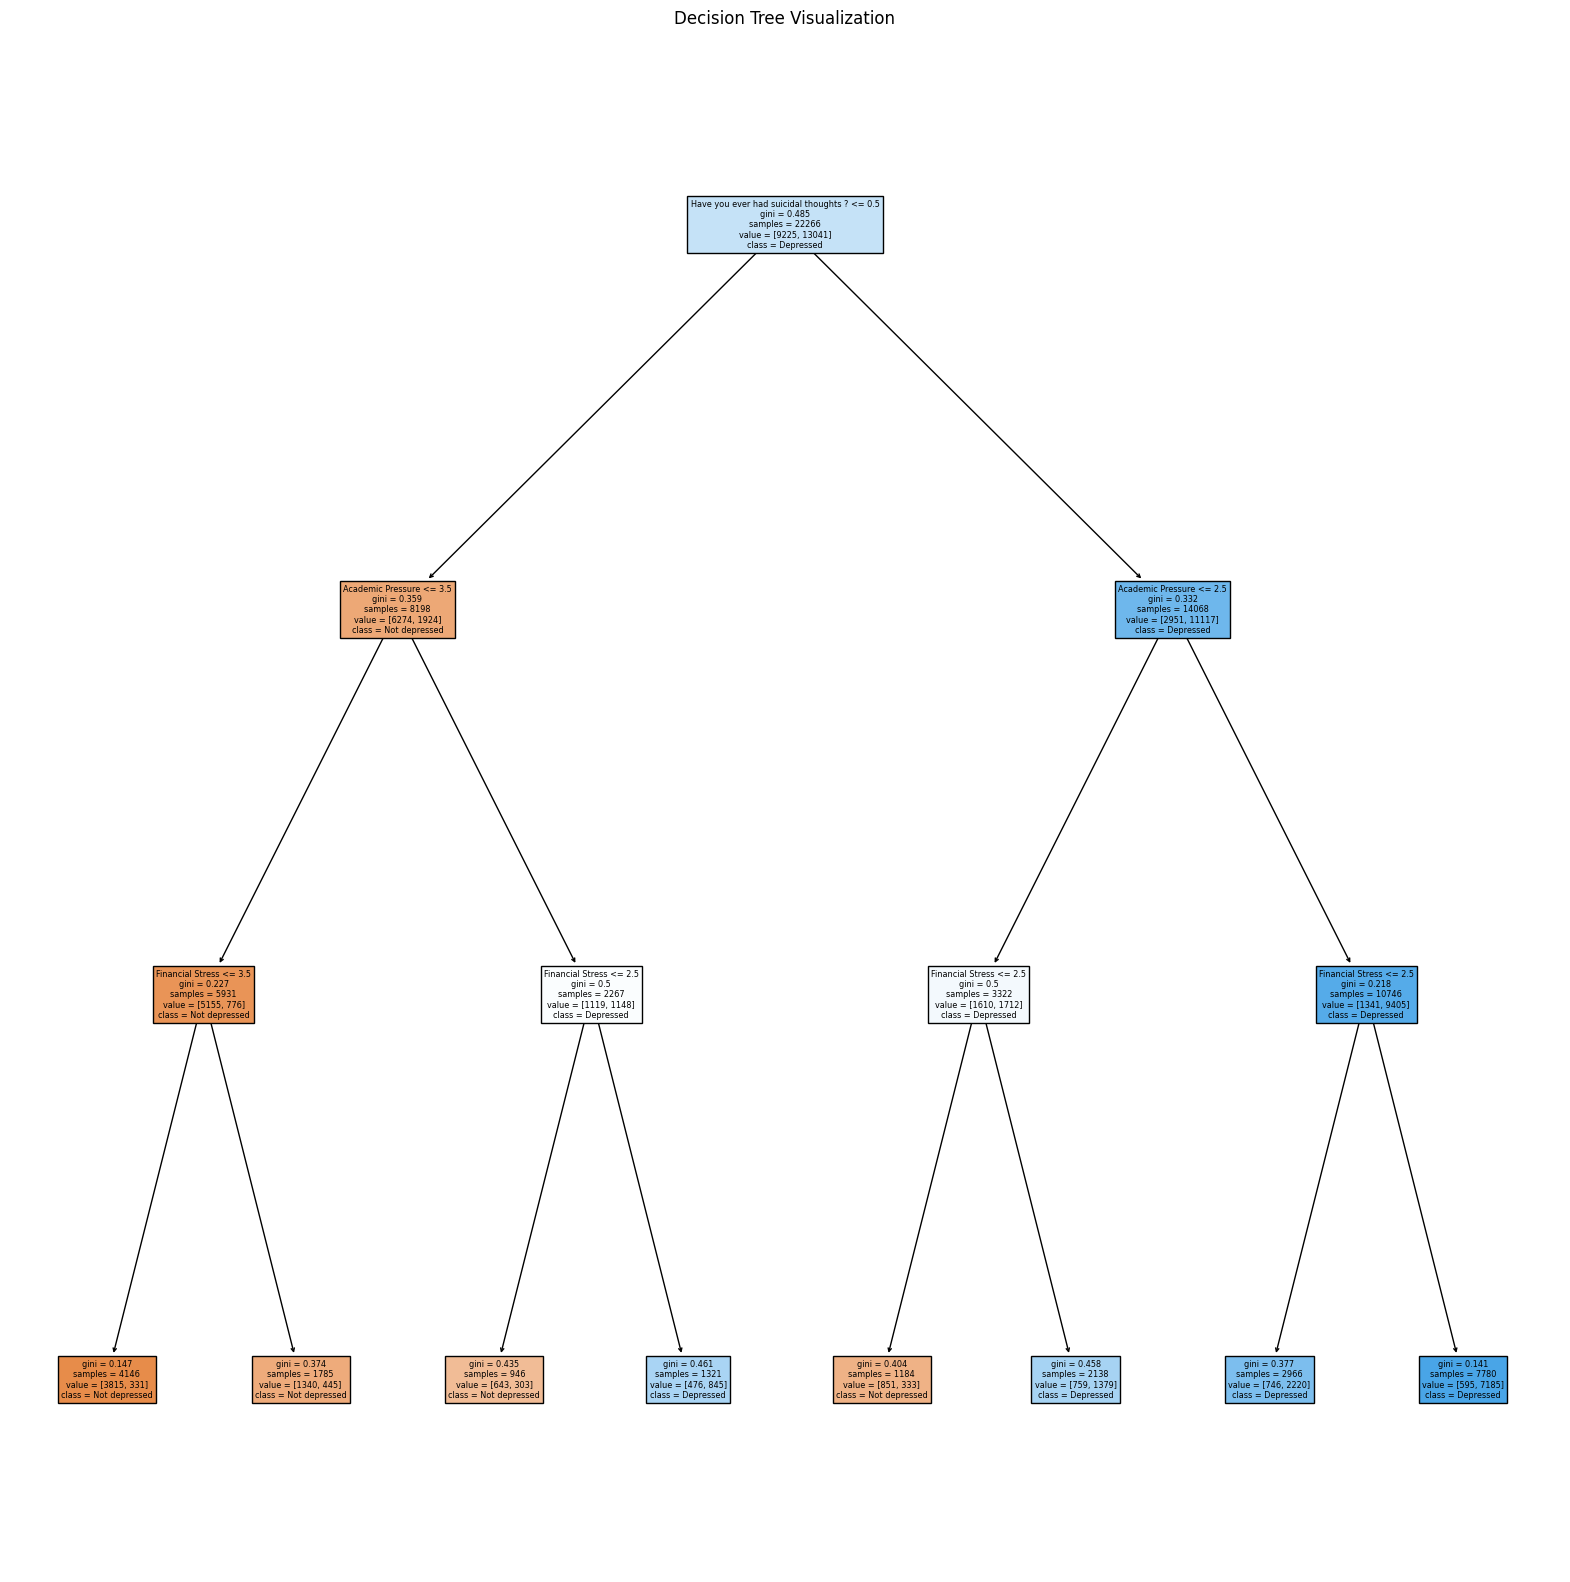

In [22]:
# Plot the decision tree
plt.figure(figsize=(20, 20))
plot_tree(best_model, filled=True, feature_names=train.columns[:-1], class_names=["Not depressed", "Depressed"])
plt.title("Decision Tree Visualization")
plt.show()